In [1]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# %matplotlib widget 
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
# notebook works with jupyter notebook and widget works better with jupyter lab. In case of
# problem with implementation look at the link https://github.com/matplotlib/ipympl



In [2]:
print(plt.style.available)
plt.style.use('fivethirtyeight')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


# Required functions

In [3]:
# Load DESA
def LoadDESA(path):
    DESA = pd.read_pickle(path)
#     DESA = DESA.drop(['EpvsHLA_Pos'], axis=1)
    return  DESA

# Load Suplimentary datasets for adjustments of Kaplan-Meier curves
def LoadKMSup():
    DSA_KM = pd.read_excel('~/UMCUtrecht/KaplanMeier/Kambruva_KM_Suplimentary_Data.xlsx')
    DESA_KM = pd.read_excel('~/UMCUtrecht/KaplanMeier/DESAsurvival.xlsx')
    return DSA_KM, DESA_KM

# DESA setter function needed for the KM Inverse Probability Weighting
def desa_num_setter(df):
    df['noDESA'] = df['#DESA'].apply(lambda x: 0 if x else 1)
    df['DESA_12'] = df['#DESA'].apply(lambda x: 1 if (x > 0 & x < 3) else 0)
    df['DESA_3orMore'] = df['#DESA'].apply(lambda x: 1 if x >= 3 else 0)
    return df

def include_mAb_data(desa_df, isotype=['IgG']):
    epitope_df = pd.read_pickle('~/Repos/STRIDE/dash_hla_3d/data/EpitopevsHLA.pickle')
    ind_mab = epitope_df.mAb == 'Yes'
    ind_igg = epitope_df['isotype'].apply(lambda x: x in isotype)
    mAb_igg = set(epitope_df[ind_mab & ind_igg].Epitope.values.tolist())
    desa_df['mAb'] = desa_df.DESA_Epitope.apply(lambda x: x.intersection(mAb_igg) )
    desa_df['#mAb'] = desa_df['mAb'].apply(lambda x: len(x) )
    return desa_df

# DESA setter function needed for the KM Inverse Probability Weighting
def ipw(df):

    import statsmodels.api as sm # import stastmodels
    import statsmodels.formula.api as smf # this allows us to use an explicit formulation like in R
 
    # estimate propensity scores and calculate weights
    model1 = smf.glm('noDESA ~ RecipientAge_NOTR +  RecipientAge_NOTR*RecipientAge_NOTR + DonorAge_NOTR + \
                    DonorAge_NOTR*DonorAge_NOTR + IL2rMoAb', data=df, family=sm.families.Binomial())
    model2 = smf.glm('DESA_12 ~ RecipientAge_NOTR +  RecipientAge_NOTR*RecipientAge_NOTR + DonorAge_NOTR + \
                    DonorAge_NOTR*DonorAge_NOTR + IL2rMoAb', data=df, family=sm.families.Binomial())
    model3 = smf.glm('DESA_3orMore ~ RecipientAge_NOTR +  RecipientAge_NOTR*RecipientAge_NOTR + DonorAge_NOTR + \
                    DonorAge_NOTR*DonorAge_NOTR + IL2rMoAb', data=df, family=sm.families.Binomial())
    result1, result2, result3 = model1.fit(), model2.fit(), model3.fit()
#     print(result1.summary())
#     print(result2.summary())
#     print(result3.summary())
    pr1raw = result1.fittedvalues
    pr2raw = result2.fittedvalues
    pr3raw = result3.fittedvalues
    # Find propensity scores 
    pr1 = pr1raw/(pr1raw + pr2raw + pr3raw)
    pr2 = pr2raw/(pr1raw + pr2raw + pr3raw)
    pr3 = pr3raw/(pr1raw + pr2raw + pr3raw)

    # Calculate the weights
    df['w'] = (df.noDESA==1) * (1/pr1) + (df.DESA_12==1) * (1/pr2) + (df.DESA_3orMore==1) * (1/pr3)
#     df['w'] =1
  # adjusted Kaplan-Meier estimator by IPW
    #Pr0 <- glm(NoDESA~ 1, family = binomial(link="logit"), data=failureData)$fitted.values[1]
    # glmfit1 <- glm(noDESA ~ RecipientAge_NOTR + RecipientAge_NOTR*RecipientAge_NOTR + DonorAge_NOTR + DonorAge_NOTR*DonorAge_NOTR + IL2rMoAb, family=binomial(link = "logit"), na.action = na.omit)
    # glmfit2 <- glm(DESA_12        ~ RecipientAge_NOTR + RecipientAge_NOTR*RecipientAge_NOTR + DonorAge_NOTR + DonorAge_NOTR*DonorAge_NOTR + IL2rMoAb, family=binomial(link = "logit"), na.action = na.omit)
    # glmfit3 <- glm(DESA_3orMore   ~ RecipientAge_NOTR + RecipientAge_NOTR*RecipientAge_NOTR + DonorAge_NOTR + DonorAge_NOTR*DonorAge_NOTR + IL2rMoAb, family=binomial(link = "logit"), na.action = na.omit)
    # Pr1raw <- glmfit1$fitted.values
    # Pr2raw <- glmfit2$fitted.values
    # Pr3raw <- glmfit3$fitted.values
    # print(length(Pr1raw) - sum(Pr1raw + Pr2raw + Pr3raw))
    # sum123raw <- Pr1raw+Pr2raw+Pr3raw
    # Pr1 <- Pr1raw / sum123raw 
    # Pr2 <- Pr2raw / sum123raw 
    # Pr3 <- Pr3raw / sum123raw 
    # print(Pr1 - Pr1raw)

    # W <- (groupCode=="noDESA") * (1/Pr1) + (groupCode=="DESA_12") * (1)/(Pr2) + (groupCode=="DESA_3orMore") * (1)/(Pr3) 
    return df


def plot_KM(df:pd.DataFrame, Title:str=None, save_as:str=None, cutoffDESA=2, *args, **kwargs):
    
    donor_type = 'Deceased'
    ci = True
    # Create and set noDESA, DESA_12, and DESA_3ormore columns
    df = desa_num_setter(df)
    
    df['noDESA'] = df['#DESA'].apply(lambda x: 0 if x else 1)
    df['DESA_12'] = df['#DESA'].apply(lambda x: 1 if (x == 1 or x == 2) else 0)
#     df['DESA_12'] = df['#DESA'].apply(lambda x: 1 if x == cutoffDESA else 0)
    df['DESA_3orMore'] = df['#DESA'].apply(lambda x: 1 if x >= 3  else 0)
#     df['DESA_3orMore'] = df['#DESA'].apply(lambda x: 1 if x != cutoffDESA  else 0)
    
    # findind the inverse probability weights
    df = ipw(df)

    # Sketch the Kaplan Meier Curves
    
    kmf1 = KaplanMeierFitter(label='No DESA')
    kmf2 = KaplanMeierFitter(label=f'1-2 DESA')
    kmf3 = KaplanMeierFitter(label=f'>{cutoffDESA} DESA')
    
    if 'TypeOfDonor_NOTR' in df.columns:
        ind_dead = df.TypeOfDonor_NOTR == donor_type
    else:
        ind_dead = df.Donor_Type == donor_type
    
    if 'Status' in df.columns:
        ind_desa = df.Status == 'DESA'
    else:
        ind_desa = df.DESA_Status == 'DESA'
    ind_ndesa = df['#DESA'].apply(lambda x:  x <= cutoffDESA) 
    
    ind_T1 = ~ind_desa & ind_dead
    ind_T2 = ind_desa & ind_ndesa & ind_dead
    ind_T3 = ind_desa & ~ind_ndesa & ind_dead
    
    if 'GraftSurvival10Y_R' in df.columns:
        failure, time = 'FailureCode10Y_R', 'GraftSurvival10Y_R'
    else:
        failure, time = 'Failure', 'Survival[Y]'
    
    T1 = df.loc[ind_T1, time]
    T2 = df.loc[ind_T2, time]
    T3 = df.loc[ind_T3, time]


    E1 = df.loc[ind_T1, failure]   # lifeline automatically ignores the 2's in the FailureCode_NOTR column
    E2 = df.loc[ind_T2, failure]    # and only consideres the 1's. This means 2's are considered as 0, as well.
    E3 = df.loc[ind_T3, failure]

    fig, ax = plt.subplots(figsize=(8, 7))

    t = np.linspace(0, 10, 1000)                           
    kmf1.fit(T1, event_observed=E1, timeline=t,)
    kmf1.plot(ci_show=ci, color='black', *args, **kwargs)

    kmf2.fit(T2, event_observed=E2, timeline=t, )
    kmf2.plot(ci_show=ci, color='blue', *args, **kwargs)

    kmf3.fit(T3, event_observed=E3, timeline=t, )
    kmf3.plot(ci_show=ci, color='red', *args, **kwargs)
    Num=ind_dead.sum()
    ax.set_title(f'{Title}, {donor_type} Donor (N={Num})', fontsize=20)
    ax.set_xlabel('Years after Tranplantation', fontsize=20)
    ax.set_ylabel('Graft Survival (%)', fontsize=20)
    ax.legend(prop={"size":15})
    ax.set_ylim(0.2)
    plt.tight_layout()
    add_at_risk_counts(kmf1, kmf2, kmf3, ax=ax, fontsize=15);
    plt.show()
    if save_as != 0:
        fname = save_as
        fig.savefig(f'./Figures/{fname}.pdf')
    # Final values
    km1_final = kmf1.survival_function_.values[-1][0]*100
    km2_final = kmf2.survival_function_.values[-1][0]*100
    km3_final = kmf3.survival_function_.values[-1][0]*100
    print(f'Top KM curve: {km1_final:.2f}, Middle KM curve: {km2_final: .2f}')
    print(f'10-Year Gap is: {km1_final - km3_final : .2f}')
    km1_final = kmf1.survival_function_.values[100][0]*100
    km3_final = kmf3.survival_function_.values[100][0]*100
    print(f'1-Year Gap is: {km1_final - km3_final : .2f}')
    
# plot_KM(DESA_old_All_Merged, 'DESA_old_All')

# Load Dataset

In [4]:
# 1: 54, 2: 47, 3: 33
DSA_KM, DESA_KM = LoadKMSup()

# ALL Epitopes

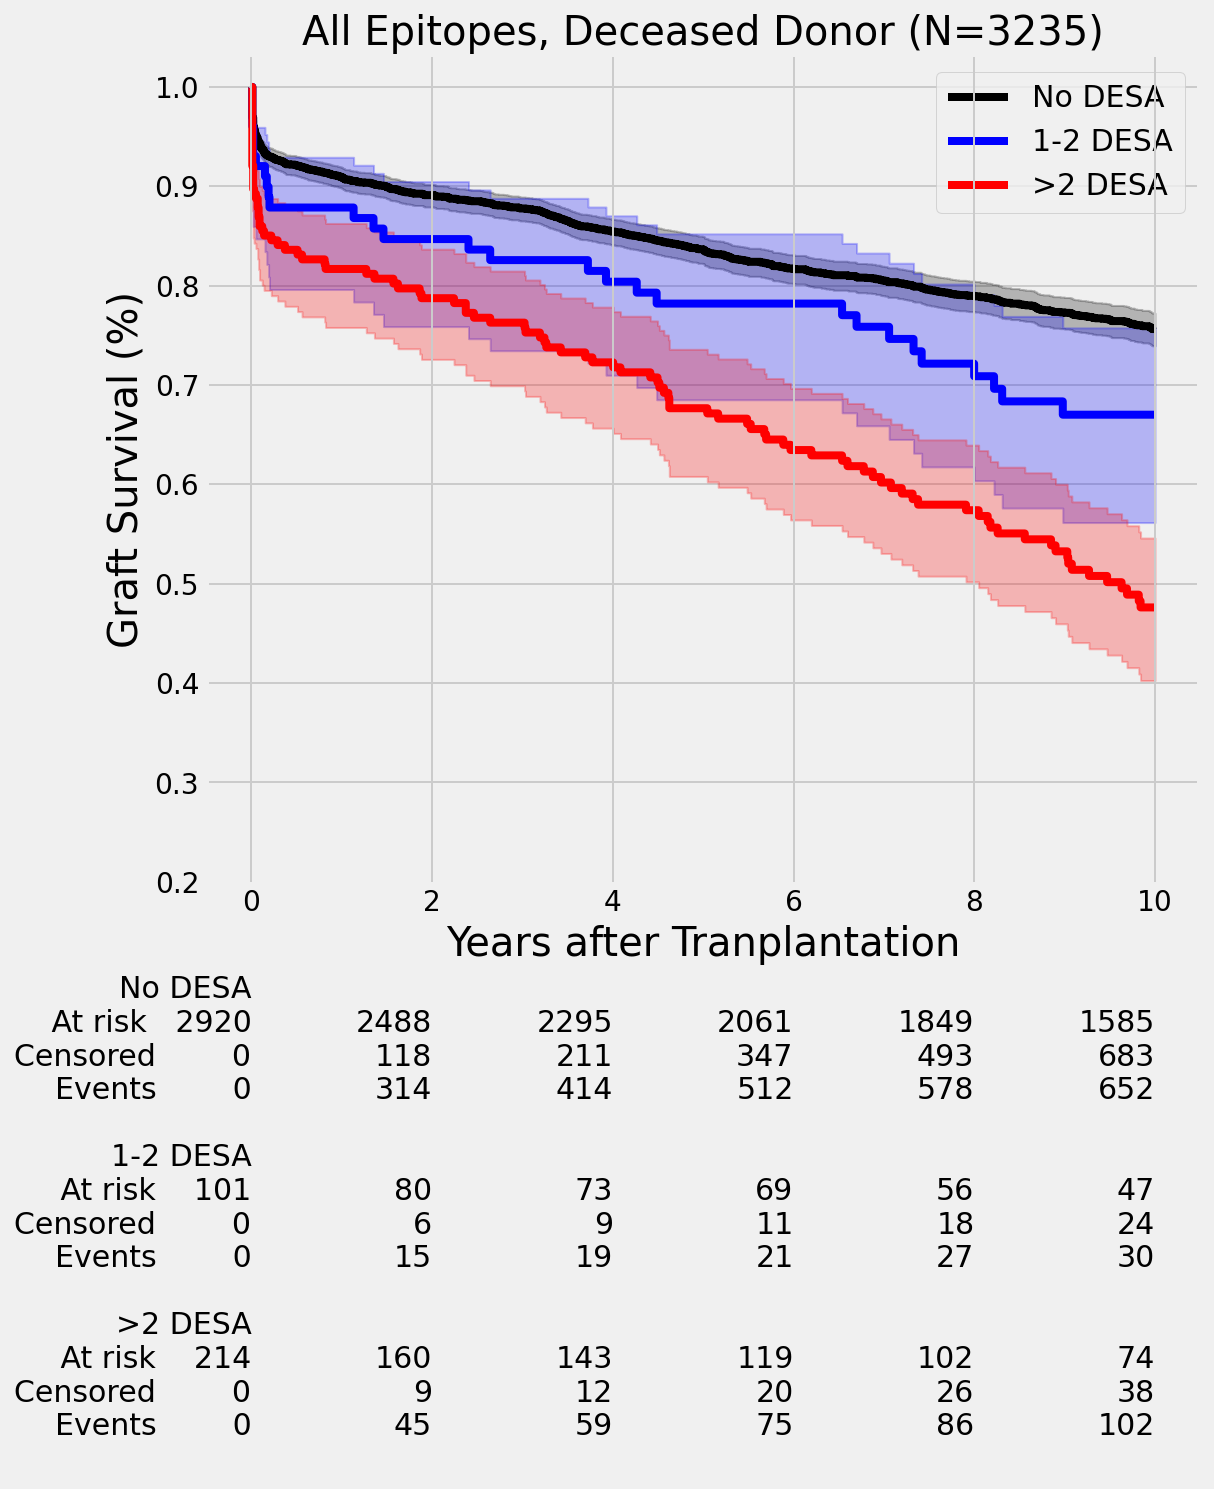

Top KM curve: 75.64, Middle KM curve:  67.01
10-Year Gap is:  28.02
1-Year Gap is:  9.21


In [5]:
# %%time
# path = '~/UMCUtrecht/ProcessedData/DSAandDESA/20200511_DESA_old_All.pickle'
path = '/Users/Danial/Repos/STRIDE/STRIDE-Analytics/data/20210325_desa.pickle'
DESA = LoadDESA(path)
DESA = DESA_KM.merge(DESA, on='TransplantID')
plot_KM(DESA, 'All Epitopes', save_as=None)


# Kaplan Meier Plot for mAbcutoffDESA

In [6]:
def plot_KM2(df:pd.DataFrame, Title:str=None, save_as:str=None, cutoffDESA=2, *args, **kwargs):
    
    donor_type = 'Deceased'

    def include_mAb_data(desa_df, isotype=['IgG']):
        epitope_df = pd.read_pickle('~/Repos/STRIDE/dash_hla_3d/data/EpitopevsHLA.pickle')
        ind_mab = epitope_df.mAb == 'Yes'
        ind_igg = epitope_df['isotype'].apply(lambda x: x in isotype)
        mAb_igg = set(epitope_df[ind_mab & ind_igg].Epitope.values.tolist())
        desa_df['mAb'] = desa_df.DESA.apply(lambda x: x.intersection(mAb_igg))
        desa_df['#mAb'] = desa_df['mAb'].apply(lambda x: len(x) )
        return desa_df

    df = include_mAb_data(df)
    df['mAb_yes'] = df['#mAb'].apply(lambda x: 1 if x else 0)
    
    # Sketch the Kaplan Meier Curves
    kmf1 = KaplanMeierFitter(label='No DESA')
    kmf2 = KaplanMeierFitter(label='no mAb')
    kmf3 = KaplanMeierFitter(label='mAb')

    if 'TypeOfDonor_NOTR' in df.columns:
        ind_dead = df.TypeOfDonor_NOTR == donor_type 
    else:
        ind_dead = df.Donor_Type == donor_type
        
    ind_desa = df.DESA_Status == 'DESA'
    ind_mAb = df.mAb_yes == 1

#     ind_T1 = ~ind_desa
#     ind_T2 = ind_desa & ind_mAb 
#     ind_T3 = ind_desa & ~ind_mAb
    ind_T1 = ~ind_desa & ind_dead
    ind_T2 = ind_desa & ~ind_mAb & ind_dead
    ind_T3 = ind_desa & ind_mAb & ind_dead

    if 'GraftSurvival10Y_R' in df.columns:
        failure, time = 'FailureCode10Y_R', 'GraftSurvival10Y_R'
    else:
        failure, time = 'Failure', 'Survival[Y]'
    
    T1 = df.loc[ind_T1, time]
    T2 = df.loc[ind_T2, time]
    T3 = df.loc[ind_T3, time]


    E1 = df.loc[ind_T1, failure]   # lifeline automatically ignores the 2's in the FailureCode_NOTR column
    E2 = df.loc[ind_T2, failure]    # and only consideres the 1's. This means 2's are considered as 0, as well.
    E3 = df.loc[ind_T3, failure]

    fig, ax = plt.subplots(figsize=(8, 7))

    t = np.linspace(0, 10, 1000)                           
    kmf1.fit(T1, event_observed=E1, timeline=t,)
    kmf1.plot(ci_show=False, color='black', *args, **kwargs)
    
    kmf2.fit(T2, event_observed=E2, timeline=t, )
    kmf2.plot(ci_show=False, color='blue', *args, **kwargs)

    kmf3.fit(T3, event_observed=E3, timeline=t, )
    kmf3.plot(ci_show=False, color='red', *args, **kwargs)

    Num=ind_dead.sum()
    ax.set_title(f'{Title}, {donor_type} Donor (N={Num})', fontsize=20)
    ax.set_xlabel('Years after Tranplantation', fontsize=20)
    ax.set_ylabel('Graft Survival (%)', fontsize=20)
    ax.legend(prop={"size":15})
    ax.set_ylim(0.2)
    plt.tight_layout()
    add_at_risk_counts(kmf1, kmf2, kmf3, ax=ax, fontsize=15);
    plt.show()
    if save_as != 0:
        fname = save_as
        fig.savefig(f'./Figures/{fname}.pdf')
    # Final values
    km1_final = kmf1.survival_function_.values[-1][0]*100
    km2_final = kmf2.survival_function_.values[-1][0]*100
    km3_final = kmf3.survival_function_.values[-1][0]*100
    print(f'Top KM curve: {km1_final:.2f}, Middle KM curve: {km2_final: .2f}')
    print(f'10-Year Gap is: {km1_final - km3_final : .2f}')
    km1_final = kmf1.survival_function_.values[100][0]*100
    km3_final = kmf3.survival_function_.values[100][0]*100
    print(f'1-Year Gap is: {km1_final - km3_final : .2f}')

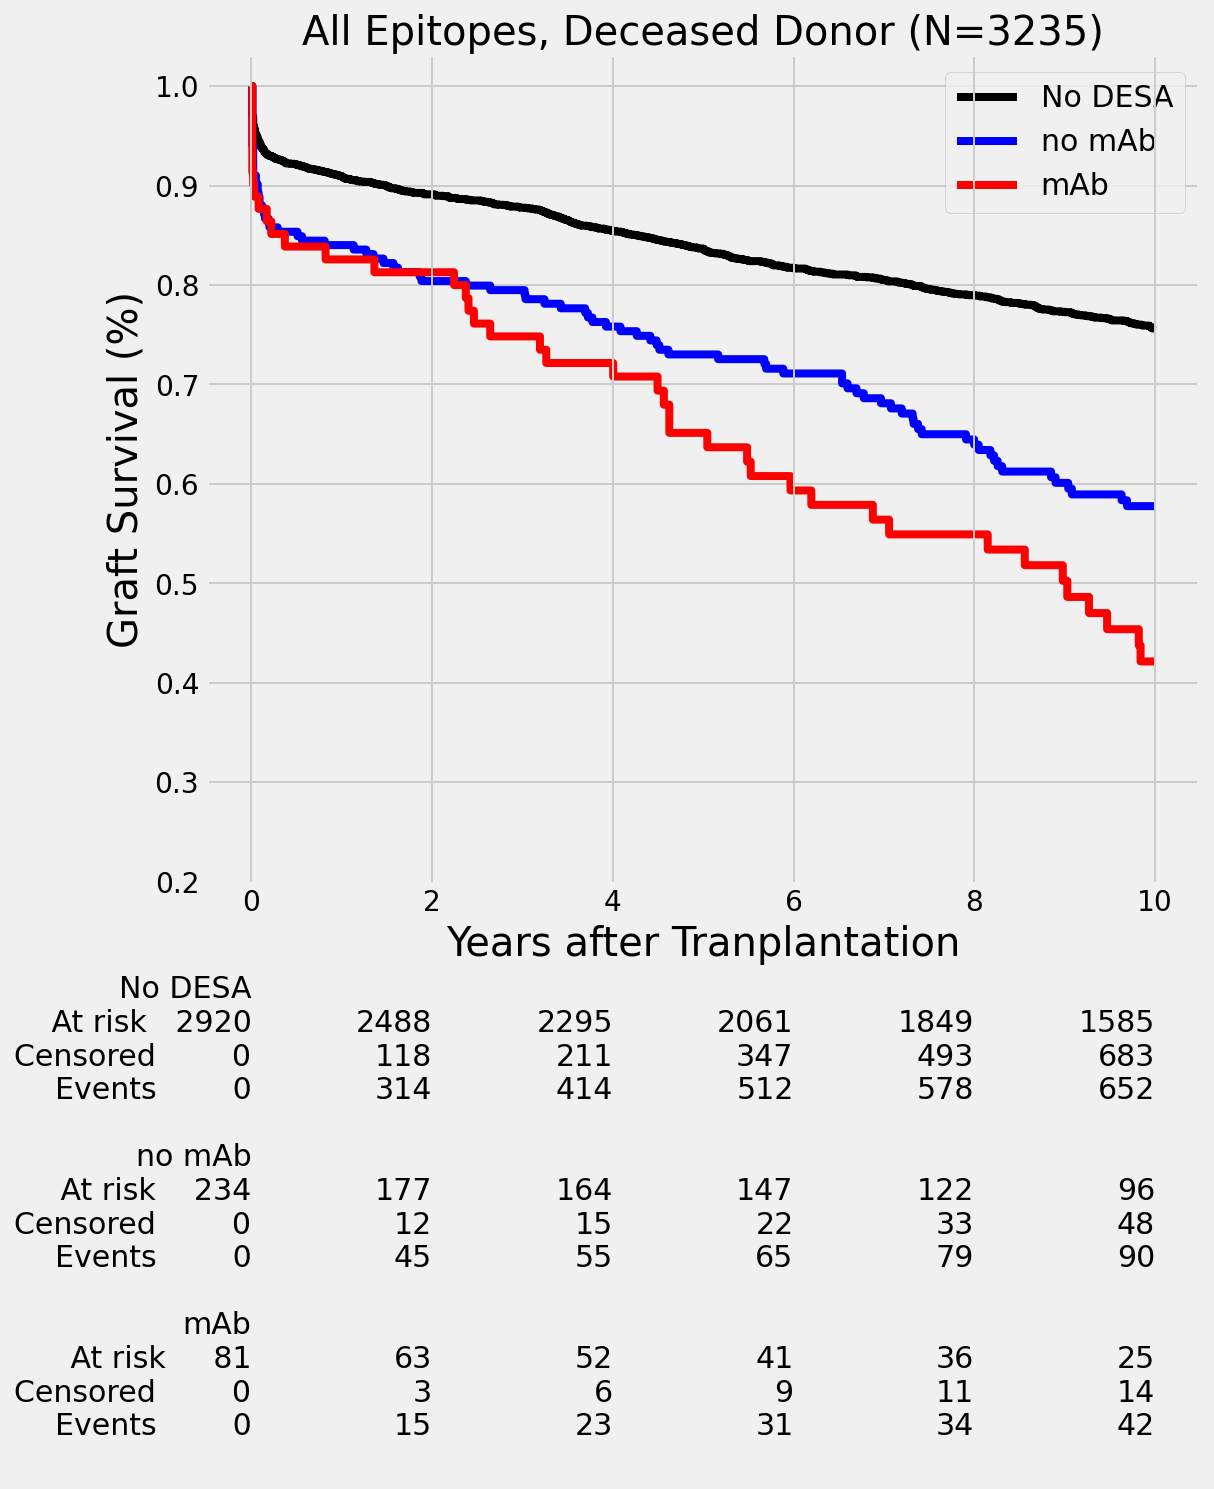

Top KM curve: 75.64, Middle KM curve:  57.77
10-Year Gap is:  33.48
1-Year Gap is:  8.32


In [7]:
# %%time

# path to output from pipeline in Dropbox/UMCU Notebooks/Find DESA/Finding DESA.ipynb
# path ='/Users/Danial/UMCUtrecht/ProcessedData/DSAandDESA/20210323_desa_old_ep_db.pickle'

# path to output from pipeline in STRIDE DATA ANALYTICS
# path = '/Users/Danial/Repos/STRIDE/STRIDE-Analytics/data/desa_old_ep_db.pickle'
path = '/Users/Danial/Repos/STRIDE/STRIDE-Analytics/data/20210325_desa.pickle'
# desa = pd.read_pickle(path)
desa = LoadDESA(path)
desa = DESA_KM.merge(desa, on='TransplantID')
plot_KM2(desa, 'All Epitopes')

# KM Curves per HLA

In [8]:
def plot_KM3(df:pd.DataFrame, Title:str=None, save_as:str=None, cut_off=1, *args, **kwargs):
    
    donor_type = 'Deceased'

    df['#HLA<-DESA'] = df.EpvsHLA_Donor.apply(lambda x: len(set(x.values())) if x else 0)
    
    
    # Sketch the Kaplan Meier Curves
    kmf1 = KaplanMeierFitter(label='No DESA')
    kmf2 = KaplanMeierFitter(label=f'{cut_off} #HLA <- DESA')
    kmf3 = KaplanMeierFitter(label='other #HLA <- DESA')

    if 'TypeOfDonor_NOTR' in df.columns:
        ind_dead = df.TypeOfDonor_NOTR == donor_type 
    else:
        ind_dead = df.Donor_Type == donor_type
        
    ind_desa = df.DESA_Status == 'DESA'
    ind_hla = df['#HLA<-DESA'] == cut_off

    ind_T1 = ~ind_desa & ind_dead
    ind_T2 = ind_desa & ind_hla & ind_dead
    ind_T3 = ind_desa & ~ind_hla & ind_dead

    if 'GraftSurvival10Y_R' in df.columns:
        failure, time = 'FailureCode10Y_R', 'GraftSurvival10Y_R'
    else:
        failure, time = 'Failure', 'Survival[Y]'
    
    T1 = df.loc[ind_T1, time]
    T2 = df.loc[ind_T2, time]
    T3 = df.loc[ind_T3, time]


    E1 = df.loc[ind_T1, failure]   # lifeline automatically ignores the 2's in the FailureCode_NOTR column
    E2 = df.loc[ind_T2, failure]    # and only consideres the 1's. This means 2's are considered as 0, as well.
    E3 = df.loc[ind_T3, failure]

    fig, ax = plt.subplots(figsize=(8, 7))

    t = np.linspace(0, 10, 1000)                           
    kmf1.fit(T1, event_observed=E1, timeline=t,)
    kmf1.plot(ci_show=False, color='black', *args, **kwargs)
    
    kmf2.fit(T2, event_observed=E2, timeline=t, )
    kmf2.plot(ci_show=False, color='blue', *args, **kwargs)

    kmf3.fit(T3, event_observed=E3, timeline=t, )
    kmf3.plot(ci_show=False, color='red', *args, **kwargs)

    Num=ind_dead.sum()
    ax.set_title(f'{Title}, {donor_type} Donor (N={Num})', fontsize=20)
    ax.set_xlabel('Years after Tranplantation', fontsize=20)
    ax.set_ylabel('Graft Survival (%)', fontsize=20)
    ax.legend(prop={"size":15})
    ax.set_ylim(0.4)
    plt.tight_layout()
    add_at_risk_counts(kmf1, kmf2, kmf3, ax=ax, fontsize=15);
    plt.show()
    if save_as != 0:
        fname = save_as
        fig.savefig(f'./Figures/{fname}.pdf')
    # Final values
    km1_final = kmf1.survival_function_.values[-1][0]*100
    km2_final = kmf2.survival_function_.values[-1][0]*100
    km3_final = kmf3.survival_function_.values[-1][0]*100
    print(f'Top KM curve: {km1_final:.2f}, Middle KM curve: {km2_final: .2f}')
    print(f'10-Year Gap is: {km1_final - km3_final : .2f}')
    km1_final = kmf1.survival_function_.values[100][0]*100
    km3_final = kmf3.survival_function_.values[100][0]*100
    print(f'1-Year Gap is: {km1_final - km3_final : .2f}')

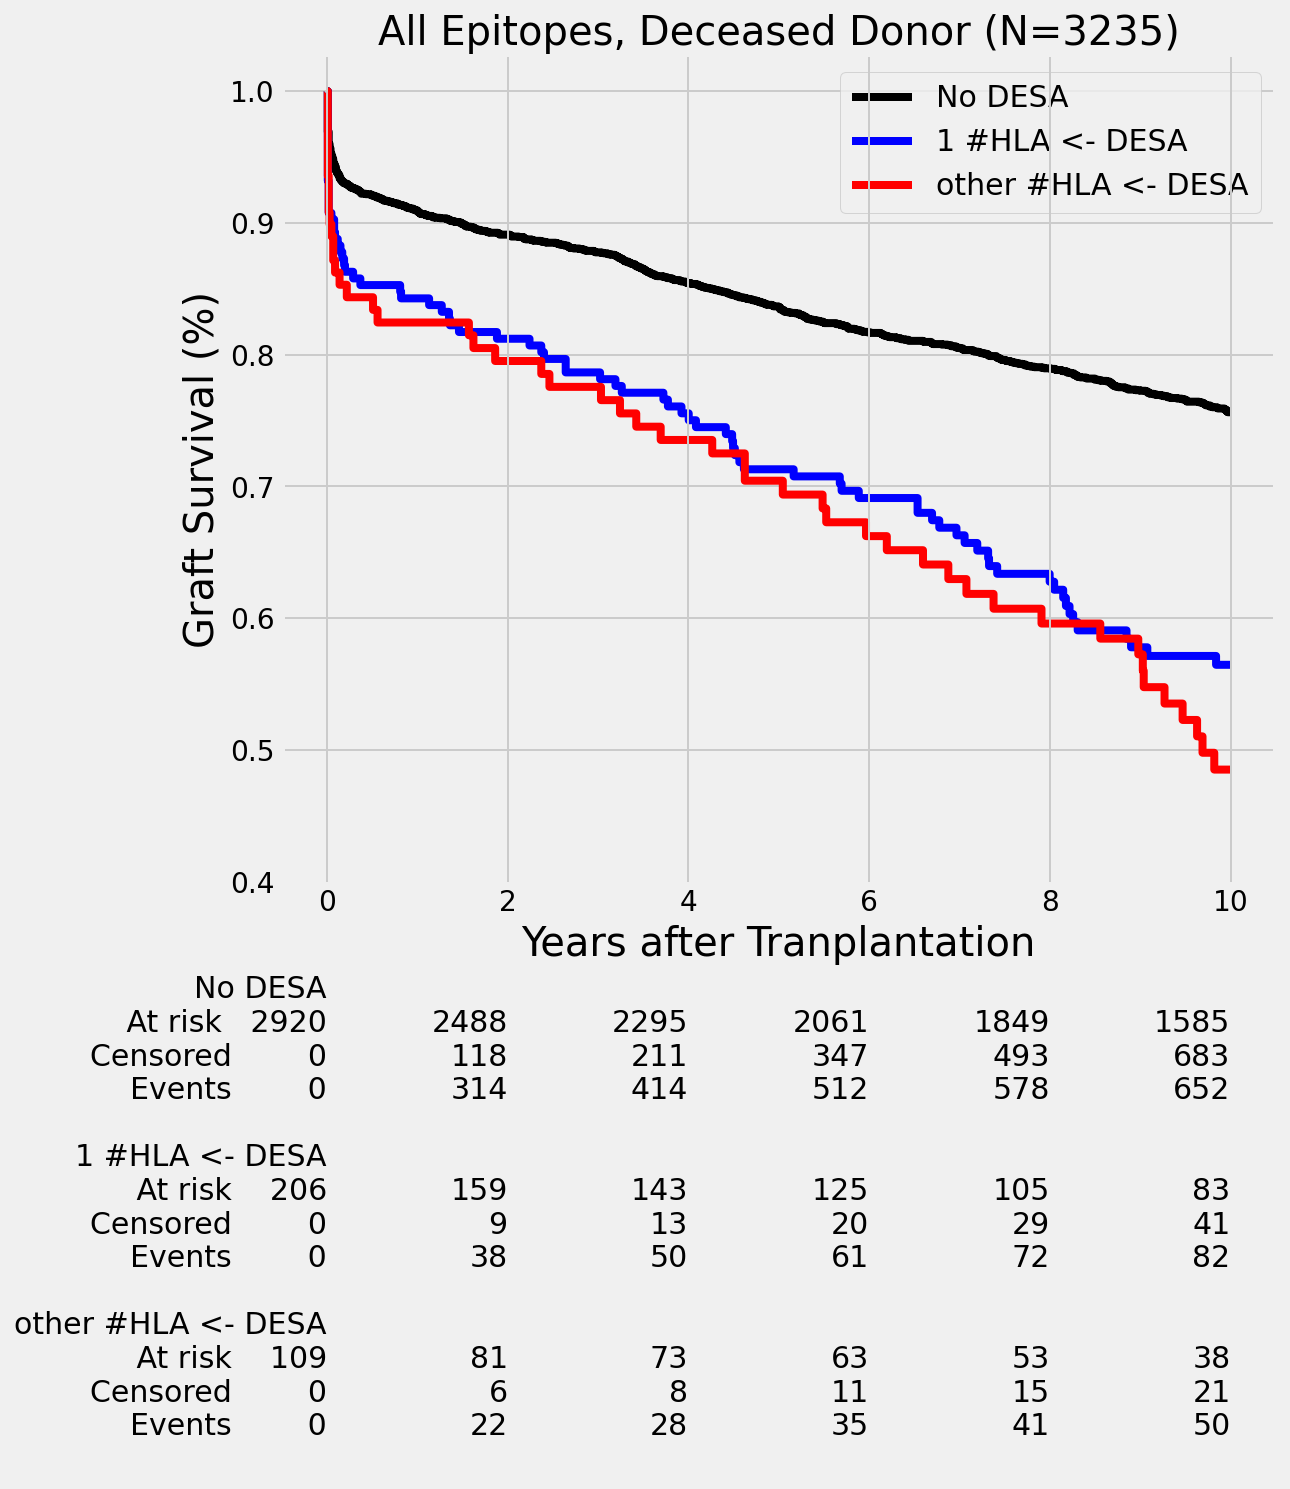

Top KM curve: 75.64, Middle KM curve:  56.47
10-Year Gap is:  27.12
1-Year Gap is:  8.44


In [9]:
path = '/Users/Danial/Repos/STRIDE/STRIDE-Analytics/data/20210325_desa.pickle'
desa = LoadDESA(path)
desa = DESA_KM.merge(desa, on='TransplantID')
plot_KM3(desa, 'All Epitopes', cut_off=1)

# KM Curves per Specific DESA

In [10]:
def km_curve(df:pd.DataFrame, desa_spec=None):
    
    donor_type = 'Deceased'
#     donor_type = 'Living'
    ci = False
    # Sketch the Kaplan Meier Curves
    kmf1 = KaplanMeierFitter(label='No DESA')
    kmf2 = KaplanMeierFitter(label='Other DESA')
    kmf3 = KaplanMeierFitter(label='Specific DESA')
    
    if 'TypeOfDonor_NOTR' in df.columns:
        ind_dead = df.TypeOfDonor_NOTR == donor_type 
    else:
        ind_dead = df.Donor_Type == donor_type
    
    ind_desa = df.DESA_Status == 'DESA'
    ind_desa_spec = df.DESA.apply(lambda x: bool(desa_spec & x))

    ind_T1 = ~ind_desa & ind_dead
    ind_T2 = ind_desa & ~ind_desa_spec & ind_dead
    ind_T3 = ind_desa & ind_desa_spec & ind_dead

    if 'GraftSurvival10Y_R' in df.columns:
        failure, time = 'FailureCode10Y_R', 'GraftSurvival10Y_R'
    else:
        failure, time = 'Failure', 'Survival[Y]'
        
    T1 = df.loc[ind_T1, time]
    T2 = df.loc[ind_T2, time]
    T3 = df.loc[ind_T3, time]


    E1 = df.loc[ind_T1, failure]   # lifeline automatically ignores the 2's in the FailureCode_NOTR column
    E2 = df.loc[ind_T2, failure]    # and only consideres the 1's. This means 2's are considered as 0, as well.
    E3 = df.loc[ind_T3, failure]

    fig, ax = plt.subplots(figsize=(8, 7))

    t = np.linspace(0, 10, 1000)                           
    kmf1.fit(T1, event_observed=E1, timeline=t,)
    kmf1.plot(ci_show=ci, color='black')
    
    kmf2.fit(T2, event_observed=E2, timeline=t, )
    kmf2.plot(ci_show=ci, color='blue')

    kmf3.fit(T3, event_observed=E3, timeline=t, )
    kmf3.plot(ci_show=ci, color='red')

    Num=ind_dead.sum()
#     ax.set_title(f'Specific Epitopes, {donor_type} Donor (N={Num})', fontsize=20)
    ax.set_title(f'Deceased Donor', fontsize=20)
    ax.set_xlabel('Years after Tranplantation', fontsize=20)
    ax.set_ylabel('Graft Survival (%)', fontsize=20)
    ax.legend(prop={"size":15})
    ax.set_ylim(0.2)
    plt.tight_layout()
    add_at_risk_counts(kmf1, kmf2, kmf3, ax=ax, fontsize=15);
    plt.show()
    # Final values
    km1_final = kmf1.survival_function_.values[-1][0]*100
    km2_final = kmf2.survival_function_.values[-1][0]*100
    km3_final = kmf3.survival_function_.values[-1][0]*100
    print(f'Top KM curve: {km1_final:.2f}, Middle KM curve: {km2_final: .2f}')
    print(f'10-Year Gap is: {km1_final - km3_final : .2f}')
    km1_final = kmf1.survival_function_.values[100][0]*100
    km3_final = kmf3.survival_function_.values[100][0]*100
    print(f'1-Year Gap is: {km1_final - km3_final : .2f}')

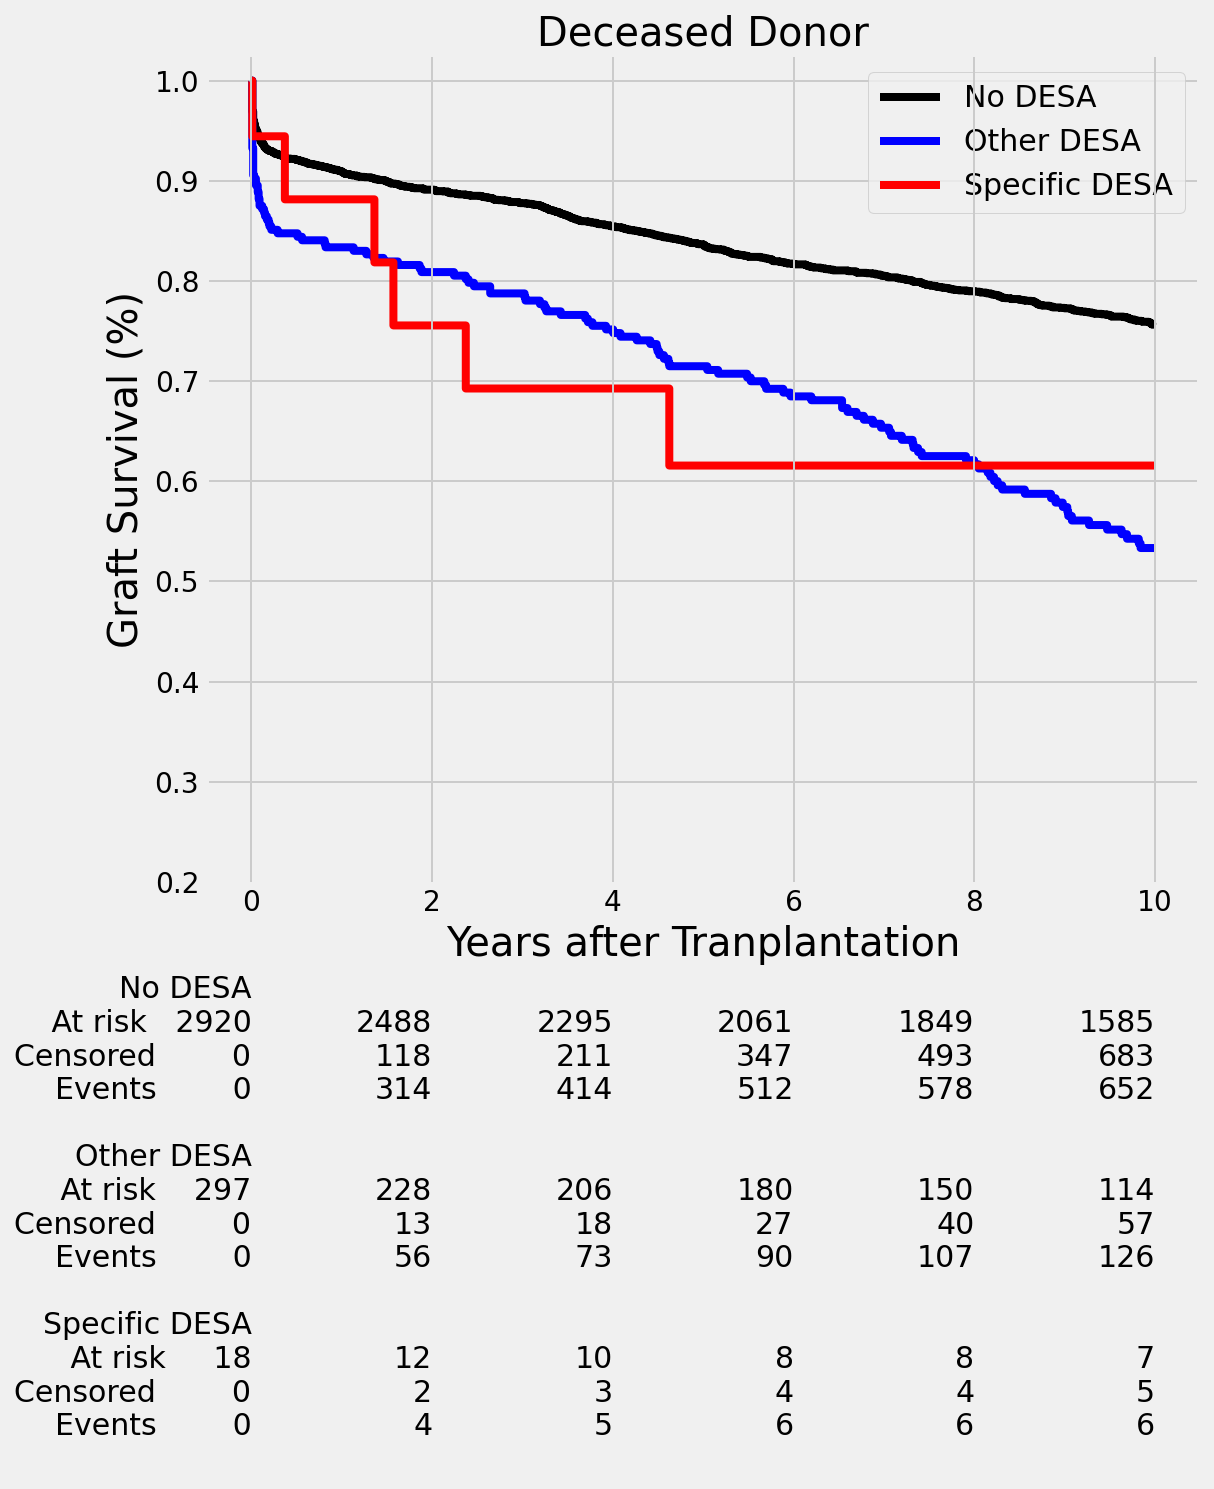

Top KM curve: 75.64, Middle KM curve:  53.33
10-Year Gap is:  14.07
1-Year Gap is:  2.74


In [20]:
path = '/Users/Danial/Repos/STRIDE/STRIDE-Analytics/data/20210325_desa.pickle'
desa_df = LoadDESA(path)
desa_df = DESA_KM.merge(desa_df, on='TransplantID')
# Not relevant 199V, 152HA, 31I, 65GK, 151AHA, 37FL, 98KN, 107W, 163LG, 163R, 57V[DR], 95V, 70QT, 70QA, 71ATD, 163RW, 57DE, 76ANT, 77NGT, 30H[DQ], 120N, 96Q, 97N, 13FE, 125G, 87Y, 
    # 173K, 66IF, 245V, 98E, 44RT, 152RA, 73AS, 55PPA, 71QS, 193PL, 76VS, 76VRN, 57V[DQ], 87F, 116I, 37YV[DQ], 125SQ, 73TVS, 80I, 30C, 267QE, 37F, 73AN, 152A, 37L, 70QRA, 177DT, 180E
    # 97S, 62LQ, 28D, 147L, 130Q, 73G, 73GQ, 104AK, 26L[DR]

# irrelevant = { '199V', '152HA', '31I', '65GK', '151AHA', '37FL', '98KN', '107W', '163LG', '163R', '57V[DR]', '95V', '70QT', '70QA', '71ATD', '163RW', '57DE', '76ANT', '77NGT',
#               '30H[DQ]', '120N', '96Q', '97N', '13FE', '125G', '87Y', '173K', '66IF', '245V', '98E', '44RT', '152RA', '73AS', '55PPA', '71QS', '193PL', '76VS', '76VRN', '57V[DQ]',
#               '87F', '116I', '37YV[DQ]', '125SQ', '73TVS', '80I', '30C', '267QE', '37F', '73AN', '152A', '37L', '70QRA', '177DT', '180E', '97S', '62LQ', '28D', '147L', '130Q', 
#               '73G', '73GQ', '104AK', '26L[DR]'}
    
# Maybe relevant: 55PP, 133RS, 185I, 144KR, 166ES, 162GLS, 66KH, 66KA, 55R, 96QN, 70GT, 70QA, 96Y, 98Q, 9T, 182N, 44KM, 51R, 67VG, 74S, 13SE, 77N[DR], 70QQ, 52PQ, 37YA, 77T[DQ]
    # 82LR, 56L, 80TA, 86A, 71KA, 114R, 166DG, 97I, 76EN, 97M, 181M, 76ESN, 71TTS, 37YV[DR], 67VT, 74EL, 16Y, 52LL, 41T, 81ALR, 76ESI, 30G[B], 38L, 71K, 70QK, 66IC, 96H, 152RR, 151AHE
    # 184A, 71SA, 47F, 70RE, 70R, 74E, 66EV, 25Q, 98ES, 17S, 80K, 253Q, 9H, 149AH, 67LQ, 71E, 70Q
    
# Relevant 45EV, 48Q, 151AHV, 156QA, 55PPD, 163RG, 151AHV, 127K, 161D, 96EV, 28H, 76ED, 96HK, 11STS, 149H, 108T, 45GV, 37S, 142M, 71A, 76ET, 80TLR, 56R, 30D, 150AAH, 70DA, 31FH, 70DRA, 
    # 45KE, 76VDT, 71TD, 62QE, 4Q, 62GRN, 74L, 30G[DR], 73ID, 67F, 66NH, 66NM, 74Y, 140TV, 46VY, 62EE, 158T, 150AH, 193AV, 30H[DR], 97V, 94I, 70DR, 6C, 65QIA, 207S, 105S, 32H
    
# Early Relevant: 9F[DQ], 45EV, 76ET, 80TLR, 245AS
# Late Relevant: 62GE, 96EV, 70QT, 57DE, 44KM, 120N, 13FE, 80TA, 71KA, 114R, 166DG, 181M, 74L, 66NM, 66IC, 151AHE, 30H[DR], 70RE, 74E, 31FY, 66EV

# Ourgalaxy teamn {'76ED', '45EV', '96EV', '149H', '96HK'} , 11STS, 108T, 45GV, 37S, 142M, 71A, 80TLR, 56R, 30D, 150AAH, 70DA, 31FH, 70DRA, 45KE, 76VDT, 71TD, 62QE, 4Q, 44RMA, 62GRN, 
# 74L, 30G[DR], 73ID, 67F, 66NH, 74Y, 74A, 140TV, 46VY, 62EE, 158T, 150AH, 245AS, 193AV, 144QL, 97V, 94I, 31FY, 6C, 65QIA, 207S, 105S, 32H

# '6C', '207S', '30G[DR]', '31FY', '32H', '44RMA', '45EV', '45GV', '45KE', '46VY', '94I', '96EV', '97V', '96HK', '11STS', '108T', '105S', '37S', '71A', 
#                              '80TLR', '56R', '30D', '150AAH', '31FH', '70DA', '70DRA','71TD', '74A', '74L', '74Y', '76VDT', '76ED',  '73ID', '62QE', '62EE', '62GRN', 
#                              '65QIA', '66NH', '67F', '4Q', '140TV', '142M', '144QL', '149H', '150AH', '158T', '158T', '193AV', '245AS'
# ALl relevant

class_I = { '44RMA', '45KE', '56R', '62EE', '62GRN', '62QE', '65QIA', '66NH', '71TD', '73ID', '74Y', '76ED', '76VDT', '80TLR', '94I', '97V', 
           '105S', '144QL', '150AAH', '150AH', '158T', '193AV', '207S', '245AS' }
class_II_dr = {'4Q', '6C', '30D', '30G[DR]', '31FY', '31FH', '32H', '37S', '67F', '70DA', '70DRA', '71A', '74A', '74L', '96EV', '96HK', '108T', '140TV', '142M', '149H'}
class_II_dq = {'45GV','45EV', '46VY'}

# High, Intermediate Ellipro 
high_int_ellipro_desa = {'32H', '67F', '70DRA', '65QIA', '6C', '73ID', '80TLR', '56R', '30D', '150AAH', '31FY', '46VY', '11STS', 
 '71A', '150AH', '96EV', '108T', '45GV', '31FH', '4Q', '37S', '105S', '140TV', '144QL', '71TD', '70DA', 
 '30G[DR]', '76VDT', '76ED', '74L', '245AS', '74A', '44RMA', '96HK', '45KE', '142M', '62QE', '62GRN', 
 '158T', '193AV', '62EE', '45EV'}
high_int_low_ellipro_desa = {'32H', '67F', '74Y', '70DRA', '6C', '65QIA', '73ID', '80TLR', '56R', '30D', '150AAH', '31FY', '46VY', '66NH', 
 '11STS', '71A', '150AH', '96EV', '108T', '45GV', '31FH', '4Q', '37S', '105S', '140TV', '144QL', '94I', '71TD', 
 '70DA', '30G[DR]', '76VDT', '76ED', '74L', '245AS', '74A', 
 '44RMA', '96HK', '45KE', '142M', '62QE', '62GRN', '158T', '193AV', '207S', '62EE', '45EV'}
late_relevant = {'62GE', '70QT', '57DE', '44KM', '120N', '13FE', '80TA', '71KA', '114R', '166DG', '181M', '66NM', 
                 '66IC', '151AHE', '30H[DR]', '70RE', '74E', '66EV', '144KR', '70QA', '16Y', '149AH'}
early_relevant = {'55R', '185I', '66KH', '66KA', '70GT', '76ET' '98Q', '67VG', '13SE', '37YA', '77T[DQ]', '76ESN', '71TTS', '51R', '9F[DQ]'}
early_irrelevant = {'76ANT', '77NGT', '13FE', '87Y', '76VS', '76VRN', '114R', '151AHE', '184A', '70RE', '70R', '74E', '98ES', '17S', '80K', '149AH'}

# km_curve(desa_df, desa_spec= class_I | class_II_dr | class_II_dq)

km_curve(desa_df, desa_spec={'199V'})

# (class_I | class_II_dr | class_II_dq ) & early_relevant

# early_irrelevant & late_relevant
# km_curve(desa_df, desa_spec={'52RR'})

In [12]:
desa_df.columns

Index(['TransplantID', 'RecipientAge_NOTR', 'RecipientSex_NOTR',
       'DonorAge_NOTR', 'DonorSex_NOTR', 'Retransplant', 'TxYear', 'Center',
       'TypeOfDonor_NOTR', 'LivingDonorNum', 'GraftFunction_NOTR',
       'ColdIschaemicPeriod_NOTR', 'CIPHour', 'CIPHour_DBD', 'CIPHour_DCD',
       'CurrentPRA_NOTR', 'HighPRA_NOTR', 'IL2rMoAb', 'GraftSurvival10y',
       'GraftSurvival10Y_R', 'GraftSurvival1y', 'GraftSurvivalY1_R',
       'FailureCode10y', 'FailureCode10Y_R', 'FailureCode1Y_R',
       'FailureCode1y', 'RejectionCodeY10_R', 'PatientSurvival10Y',
       'PatientDeathCode10Y', 'GraftSurvival3m', 'FailureCode3m',
       'DESA_Status', 'EpvsHLA_Donor', '#DESA', 'DESA'],
      dtype='object')

# 

In [13]:
def delta(df:pd.DataFrame, desa_spec=None):
    ci=False
    if isinstance(desa_spec, str):
        desa_spec = set([desa_spec])
    
    donor_type = 'Deceased'

    # Sketch the Kaplan Meier Curves
    kmf1 = KaplanMeierFitter(label='No DESA')
    kmf2 = KaplanMeierFitter(label='Other DESA')
    kmf3 = KaplanMeierFitter(label='Specific DESA')
    
    if 'TypeOfDonor_NOTR' in df.columns:
        ind_dead = df.TypeOfDonor_NOTR == donor_type 
    else:
        ind_dead = df.Donor_Type == donor_type
    
    ind_desa = df.DESA_Status == 'DESA'
    ind_desa_spec = df.DESA.apply(lambda x: bool(desa_spec & x))

    ind_T1 = ~ind_desa & ind_dead
    ind_T2 = ind_desa & ~ind_desa_spec & ind_dead
    ind_T3 = ind_desa & ind_desa_spec & ind_dead

    if 'GraftSurvival10Y_R' in df.columns:
        failure, time = 'FailureCode10Y_R', 'GraftSurvival10Y_R'
    else:
        failure, time = 'Failure', 'Survival[Y]'
        
    T1 = df.loc[ind_T1, time]
    T2 = df.loc[ind_T2, time]
    T3 = df.loc[ind_T3, time]


    E1 = df.loc[ind_T1, failure]   # lifeline automatically ignores the 2's in the FailureCode_NOTR column
    E2 = df.loc[ind_T2, failure]    # and only consideres the 1's. This means 2's are considered as 0, as well.
    E3 = df.loc[ind_T3, failure]

    t = np.linspace(0, 10, 1000)                           
    kmf1.fit(T1, event_observed=E1, timeline=t,)
    kmf2.fit(T2, event_observed=E2, timeline=t, )
    kmf3.fit(T3, event_observed=E3, timeline=t, )
    return (ind_desa_spec & ind_dead).sum(), kmf2.subtract(kmf3)
    


# Diff plots per DESA

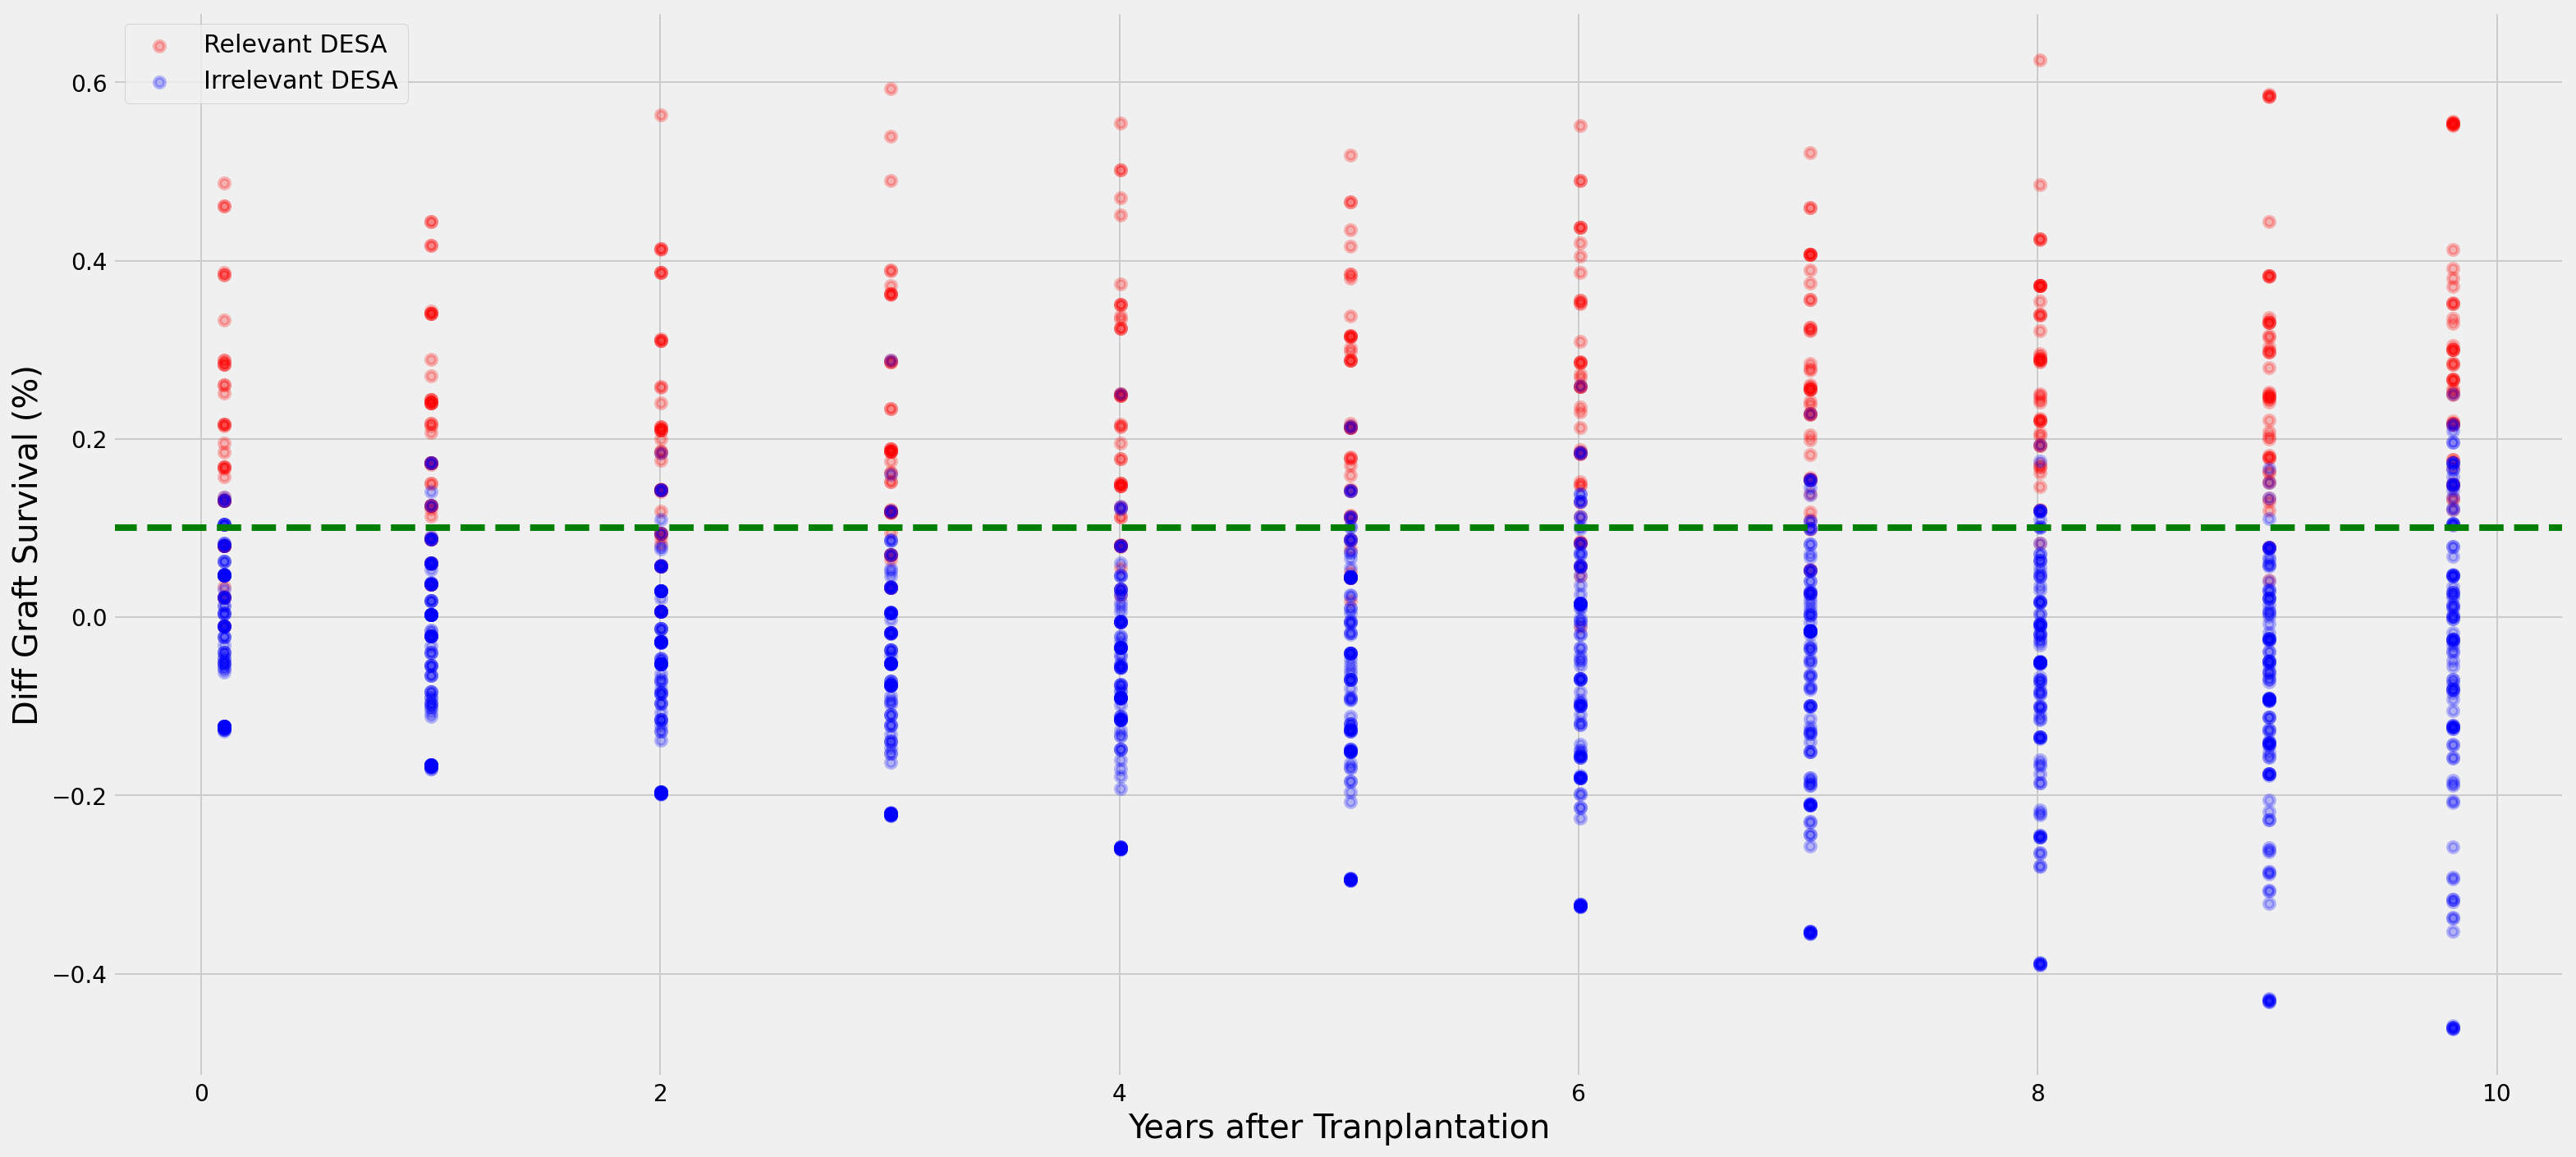

In [21]:
from lifelines.plotting import plot_lifetimes
class_I_A = {
    '150AAH', '56R', '62EE', '62QE', '66NH', '76VDT',
    '105S', '73ID', '207S', '245AS', '193AV', '150AH'
            }

class_I_B = {
    '44RMA', '45KE', '62GRN',  '71TD',  '76ED', '80TLR',
    '74Y', '65QIA', '94I', '97V', '158T', '144QL', 
            }
class_II_dq = {'45EV', '96HK', '76ED'}
class_II_drb1 = {'31FY', '37S', '74L', '96HK', '142M'}
class_II_dr134 = {'4Q', '31FH', '32H', '149H'}
class_II_dr5 = {
    '96EV', '108T', '30D', '71A', '70DA', 
    '67F', '30G[DR]', '70DRA', '74A', '6C', 
               }

class_I = { '44RMA', '45KE', '56R', '62EE', '62GRN', '62QE', '65QIA', '66NH', '71TD', '73ID', '74Y', '76ED', '76VDT', '80TLR', '94I', '97V', 
           '105S', '144QL', '150AAH', '150AH', '158T', '193AV', '207S', '245AS' }
class_II_dr = {'4Q', '6C', '30D', '30G[DR]', '31FY', '31FH', '32H', '37S', '67F', '70DA', '70DRA', '71A', '74A', '74L', '96EV', '96HK', '108T', '140TV', '142M', '149H'}
class_II_dq = {'45GV','45EV', '46VY'}

relevant_desa = class_I | class_II_dr | class_II_dq 

# ad_hoc = {'199V', '65GK', '151AHA', '37FL', '98KN', '163LG', '152HA', '31I', '65GK'}

# Irrelevant:
#     early_irrelevant: '76ANT', '77NGT', '13FE', '87Y', '76VS', '76VRN', '114R', '151AHE', '184A', '70RE', '70R', '74E', '98ES', '17S', '80K', '149AH'
#     late_irrelevant: '30H[DQ]', '253Q', '65QIA'
#     irrelevant: '151AHA', '37FL', '98KN', '31I', '57V[DR]', '70QT', '70QA', '71ATD', '163RW', '120N', '97N', '125G', '173K', '245V', '44RT', '152RA', '55PPA', '71QS', '193PL', '57V[DQ]'
#                 '73TVS', '116I', '37YV[DQ]', '125SQ', '80I', '30C', '267QE', '37F', '73AN', '152A', '37L', '70QRA', '177DT', '180E', '97S', '62LQ', '28D', '147L', '130Q', '73G'
#                 '73GQ', '104AK', '26L[DR]', '152RR'
# irrelevant_ordered = '26L[DR]', '28D', '30C', '31I', '37F', '37FL', '37YV[DQ]', '44RT','55PPA' , '57V[DR]', '57V[DQ]', '62LQ', '70QRA', '70QT', '70QA', '71ATD', '71QS', '73AN', '73G', '73TVS',  '73GQ', 
# '80I', '97S', '97N', '98KN', '104AK', '116I', '120N','125SQ', '125G', '130Q', '147L', '151AHA', '152A', '152RA', '152RR', '163RW', '173K', '177DT', '180E', '193PL',  '245V', '267QE' 
#     band_irrelevant: '199V', '65GK', '163LG', '152HA', '107W', '163R', '95V', '57DE', '96Q', '66IF', '98E', '73AS', '87F', 
#       - from maybe relevant: '55PP', '133RS', '185I', '166ES', '162GLS', '66KH', '66KA', '55R', '96QN', '70GT', '96Y', '98Q', '9T', '182N', '51R', '67VG', '74S', '13SE', '77N[DR]',
#                              '70QQ', '52PQ', '37YA', '77T[DQ]', '82LR', '56L', '86A', '71KA', '166DG', '97I', '76EN', '97M', '76ESN', '71TTS', '37YV[DR]', '67VT', '74EL', '52LL', 
#                              '41T', '81ALR', '76ESI', '30G[B]', '38L', '71K', '70QK', '66IC', '96H', '71SA', '47F', '17S', '9H',

#     from maybe relevant: 
#           late_relevant: '144KR', '70QA', '44KM', '114R', '181M', '16Y', '66EV', '149AH'
#           early_relevant: '80TA', '97I'

irrelevant_ordered = {'26L[DR]', '28D', '30C', '31I', '37F', '37FL', '37YV[DQ]', '44RT','55PPA' , '57V[DR]', '57V[DQ]', '62LQ', '70QRA', '70QT', '70QA', '71ATD', 
                      '71QS', '73AN', '73G', '73TVS',  '73GQ', '80I', '97S', '97N', '98KN', '104AK', '116I', '120N','125SQ', '125G', '130Q', '147L', '151AHA', 
                      '152A', '152RA', '152RR', '163RW', '173K', '177DT', '180E', '193PL',  '245V', '267QE'}

band_irrelevant = {'65GK', '163LG', '152HA', '107W', '163R', '95V', '57DE', '96Q', '66IF', '98E', '73AS', '87F', '55PP', '133RS', '185I', '166ES', '162GLS', '66KH', 
                    '66KA', '55R', '96QN', '70GT', '96Y', '98Q', '9T', '182N', '51R', '67VG', '74S', '13SE', '77N[DR]', '70QQ', '52PQ', '37YA', '77T[DQ]', '82LR', 
                   '56L', '86A', '71KA', '166DG', '97I', '76EN', '97M', '76ESN', '71TTS', '37YV[DR]', '67VT', '74EL', '52LL', '41T', '81ALR', '76ESI', '30G[B]', '38L', 
                   '71K', '70QK', '66IC', '96H', '71SA', '47F', '17S', '9H',}




def plot_diff(desas):
    fig, ax = plt.subplots(figsize=(22, 10), )
    for desa in desas:
        num, diff = delta(desa_df, desa)
        ax.plot(diff, label=f'DESA: {desa}, #TX:{num}', linewidth=2)
        plt.axhline(0.1, color='r', linestyle='dashed')
        plt.axhline(-0.1, color='r', linestyle='dashed')
        plt.axhline(0.05, color='black', linestyle='dashed')
        plt.axhline(-0.05, color='black', linestyle='dashed')
        ax.set_title(f'HLA DQ', fontsize=20)
        ax.set_xlabel('Years after Tranplantation', fontsize=20)
        ax.set_ylabel('Diff Graft Survival (%)', fontsize=20)
        ax.legend(prop={"size":15})
        plt.tight_layout()

def plot_scatter_diff(desa_sets):
    from collections import defaultdict
    
    time_points = [10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 980]
    fig, ax = plt.subplots(figsize=(22, 10), )
    colors = [ 'red', 'blue',]
    labels = [ 'Relevant DESA', 'Irrelevant DESA']
    diffs = defaultdict(lambda : defaultdict(list))
    for i, desa_set in enumerate(desa_sets):
        for desa in desa_set:
            num, diff = delta(desa_df, desa)
            diffs[i]['x'].append(diff.index[time_points])
            diffs[i]['y'].append(diff.values[time_points])
#         print(diffs)
    
    ax.scatter(diffs[0]['x'], diffs[0]['y'], color=colors[0], label=labels[0], linewidth=2.5, alpha = 0.25)
    ax.scatter(diffs[1]['x'], diffs[1]['y'], color=colors[1], label=labels[1], linewidth=2.5, alpha= 0.25)
    ax.scatter(diffs[2]['x'], diffs[2]['y'], color=colors[1], linewidth=2.5, alpha= 0.25)
    #         ax.scatter(diff.index[time_points], diff.values[time_points], color=colors[i], linewidth=1.5)
    plt.axhline(0.1, color='green', linestyle='dashed')
#     plt.axhline(-0.1, color='green', linestyle='dashed')
#     plt.axhline(0.05, color='black', linestyle='dashed'),
#     plt.axhline(-0.05, color='black', linestyle='dashed')
    ax.set_xlabel('Years after Tranplantation', fontsize=20)
    ax.set_ylabel('Diff Graft Survival (%)', fontsize=20)
    ax.legend(prop={"size":15})
    plt.tight_layout()

desas = [relevant_desa, irrelevant_ordered | band_irrelevant]
plot_scatter_diff(desas)